# Robust Fruit Image Classification of Perturbed Images using a VGG16 based model
First we upload the IndusFruit dataset. The dataset contains 3,640 fruit images belonging to seven different fruit classes. The fruit classes included in the dataset are:

1.   Apple
2.   Banana
3.   Grape
4.   Mango
5.   Orange
6.   Strawberry
7.   Watermelon

The dataset is sub-divided into three subsets i.e. train (400 images per fruit class), validation (40 images per fruit class) and test (80 images per fruit class). 

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Indus Fruit Dataset_Resized Images_100_100.zip to Indus Fruit Dataset_Resized Images_100_100.zip


Now after uploading the dataset, we unzip it:

In [ ]:
!unzip 'Indus Fruit Dataset_Resized Images_100_100.zip'

Archive:  Indus Fruit Dataset_Resized Images_100_100.zip
   creating: Indus Fruit Dataset_Resized Images_100_100/Test/
   creating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/apple_104.jpg  
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/apple_106.jpg  
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/apple_11.jpg  
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/apple_116.jpg  
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/apple_120.jpg  
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/apple_121.jpg  
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/apple_124.jpg  
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/apple_125.jpg  
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/apple_13.jpg  
  inflating: Indus Fruit Dataset_Resized Images_100_100/Test/apple/a

## Model Definition

We now define our model:

In [ ]:
import os
import shutil
import glob
import random
import cv2
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import keras
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint

First we download VGG16 pre-trained model:

In [ ]:
conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(100,100,3))

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Now, we add classifier on top of the convolutional base (i.e. feature extractor):

In [ ]:
import numpy as np
import keras
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.python.keras.callbacks import ModelCheckpoint

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=1e-4),metrics=['categorical_accuracy'])
model.summary()

filepath="VGG16_IndusFruit_AdversarialLearning_1st Experiment_GC.h5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True)
callbacks_list = [checkpoint]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                147488    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 14,862,407
Trainable params: 14,862,407
Non-trainable params: 0
_________________________________________________________________


In [ ]:
resized_images_100_100_train_dir='/content/Indus Fruit Dataset_Resized Images_100_100/Train'
resized_images_100_100_test_dir='/content/Indus Fruit Dataset_Resized Images_100_100/Test'
resized_images_100_100_validation_dir='/content/Indus Fruit Dataset_Resized Images_100_100/Validation'

Here we set data generators for model training, validation and testing:

In [ ]:
batch_size=16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation  and test data should not be augmented!
validation_datagen=ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        resized_images_100_100_train_dir,
        target_size=(100, 100),
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        resized_images_100_100_validation_dir,
        target_size=(100, 100),
        batch_size=batch_size, shuffle=False)

test_generator = test_datagen.flow_from_directory(
        resized_images_100_100_test_dir,
        target_size=(100, 100),
        batch_size=batch_size, shuffle=False)

Found 2800 images belonging to 7 classes.
Found 280 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


In [ ]:
number_of_training_samples=2800
number_of_validation_samples=280
number_of_test_samples=560

## Model Training
Now we train and validate our model on regular images:

In [ ]:
import math

history = model.fit_generator(
      train_generator,
      steps_per_epoch=math.ceil(number_of_training_samples//batch_size),
      epochs=200,
      callbacks=callbacks_list,
      validation_data=validation_generator,
      validation_steps=math.ceil(number_of_validation_samples//batch_size))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
175/175 [==============================] - 24s 139ms/step - loss: 1.5109 - categorical_accuracy: 0.4229 - val_loss: 1.0183 - val_categorical_accuracy: 0.6397
Epoch 2/200
175/175 [==============================] - 24s 137ms/step - loss: 0.9451 - categorical_accuracy: 0.6854 - val_loss: 0.6828 - val_categorical_accuracy: 0.7794
Epoch 3/200
175/175 [==============================] - 24s 136ms/step - loss: 0.7291 - categorical_accuracy: 0.7704 - val_loss: 0.5319 - val_categorical_accuracy: 0.8235
Epoch 4/200
175/175 [==============================] - 24s 136ms/step - loss: 0.5572 - categorical_accuracy: 0.8264 - val_loss: 0.3834 - val_categorical_accuracy: 0.8934
Epoch 5/200
175/175 [==============================] - 24s 137ms/step - loss: 0.4751 - categorical_accuracy: 0.8700 - val_loss: 0.2842 - val_categorical_accuracy: 0.9191
Epoch 6/200
175/175 [==============================] - 23s 134ms/step - lo

Here, we visualize training of our model on regular images:

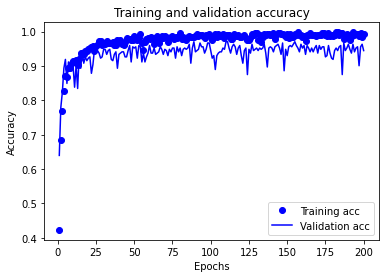

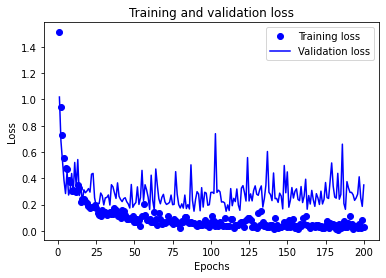

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Loading Train and Test Data Images

In [ ]:
import glob
from pathlib import Path
from tensorflow.keras.utils import to_categorical
import cv2

apple_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Train/apple')
banana_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Train/banana')
orange_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Train/orange')
watermelon_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Train/watermelon')
mango_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Train/mango')
grape_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Train/grape')
strawberry_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Train/strawberry')

apple_cases = apple_cases_dir.glob('*.jpg')
banana_cases = banana_cases_dir.glob('*.jpg')
orange_cases = orange_cases_dir.glob('*.jpg')
watermelon_cases = watermelon_cases_dir.glob('*.jpg')
mango_cases = mango_cases_dir.glob('*.jpg')
grape_cases = grape_cases_dir.glob('*.jpg')
strawberry_cases = strawberry_cases_dir.glob('*.jpg')

train_data = []
train_labels = []

for img in apple_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    train_data.append(img)
    train_labels.append(label)

for img in banana_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    train_data.append(img)
    train_labels.append(label)

for img in grape_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [2]
    train_data.append(img)
    train_labels.append(label)
    
for img in mango_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [3]
    train_data.append(img)
    train_labels.append(label)

for img in orange_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [4]
    train_data.append(img)
    train_labels.append(label)

for img in strawberry_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [5]
    train_data.append(img)
    train_labels.append(label)

for img in watermelon_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [6]
    train_data.append(img)
    train_labels.append(label)

train_data = np.array(train_data)
train_labels = np.array(train_labels)
train_labels_one_hot_encoding=to_categorical(train_labels)

print("Total number of train examples: ", train_data.shape)
print("Total number of train labels:", train_labels.shape)

Total number of train examples:  (2800, 100, 100, 3)
Total number of train labels: (2800, 1)


In [ ]:
apple_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Test/apple')
banana_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Test/banana')
orange_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Test/orange')
watermelon_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Test/watermelon')
mango_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Test/mango')
grape_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Test/grape')
strawberry_cases_dir = Path('/content/Indus Fruit Dataset_Resized Images_100_100/Test/strawberry')

apple_cases = apple_cases_dir.glob('*.jpg')
banana_cases = banana_cases_dir.glob('*.jpg')
orange_cases = orange_cases_dir.glob('*.jpg')
watermelon_cases = watermelon_cases_dir.glob('*.jpg')
mango_cases = mango_cases_dir.glob('*.jpg')
grape_cases = grape_cases_dir.glob('*.jpg')
strawberry_cases = strawberry_cases_dir.glob('*.jpg')

test_data = []
test_labels = []

for img in apple_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [0]
    test_data.append(img)
    test_labels.append(label)

for img in banana_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [1]
    test_data.append(img)
    test_labels.append(label)

for img in grape_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [2]
    test_data.append(img)
    test_labels.append(label)
    
for img in mango_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [3]
    test_data.append(img)
    test_labels.append(label)

for img in orange_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [4]
    test_data.append(img)
    test_labels.append(label)

for img in strawberry_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [5]
    test_data.append(img)
    test_labels.append(label)

for img in watermelon_cases:
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = [6]
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_labels_one_hot_encoding=to_categorical(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of test labels:", test_labels.shape)

Total number of test examples:  (560, 100, 100, 3)
Total number of test labels: (560, 1)


## Loading and Evaluating the Best Model
Now we load the best model obtained as a result of training on regular images. 

In [ ]:
from tensorflow.python.keras.models import load_model

best_model = load_model('VGG16_IndusFruit_AdversarialLearning_1st Experiment_GC.h5')

Now we evaluate the best model on the test set of regular images:

In [ ]:
# Evaluation on test dataset

test_loss, test_score = best_model.evaluate(test_data, test_labels_one_hot_encoding, batch_size=8)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

70/70 [==============================] - 2s 35ms/step - loss: 0.1963 - categorical_accuracy: 0.9518
Loss on test set:  0.19632500410079956
Accuracy on test set:  0.9517857432365417


# Generation of Adversarial Images for Model Fine-Tuning
First we import some packages..

In [ ]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import random

import matplotlib.pyplot as plt

Here we define a function that will generate adversarial pattern using Fast Gradient Signed Method (FGSM). FGSM enables us to perform white box untargeted attack.

In [ ]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

Here we generate a sample adversarial image....

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


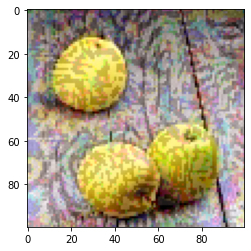

In [ ]:
img_rows=100
img_cols=100
channels=3
image = train_data[50]
image_label=train_labels[50]
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adversarial = image + perturbations * 0.1
plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

Here we display the same image in its original form:

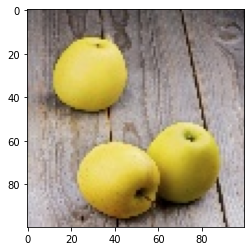

In [ ]:
plt.imshow(train_data[50])

Predicting the fruit image class for both the original image as well as the perturbed image using the model trained solely on regular images.

In [ ]:
print(best_model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax())
print(best_model.predict(adversarial).argmax())

0
3


Now we define data generators for both train and test adversarial images:

In [ ]:
# Adversarial train data generator
def generate_train_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 2799)

            label = train_labels[N]
            image = train_data[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(train_labels[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [ ]:
# Adversarial test data generator
def generate_test_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 559)

            label = test_labels[N]
            image = test_data[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(test_labels[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

Here we generate 20 adversarial images. We use the model (trained on regular images) to predict their class. The true class is shown along with the predicted class.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 0 Truth: [0]


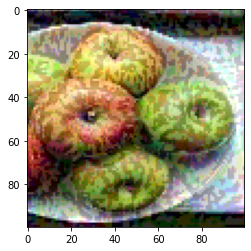

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 2 Truth: [3]


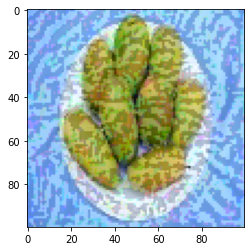

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 6 Truth: [6]


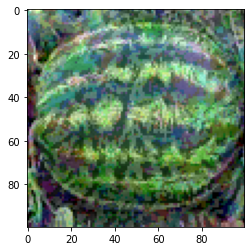

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1 Truth: [1]


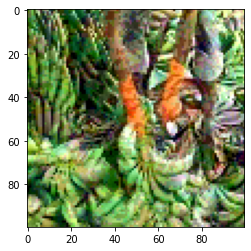

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 5 Truth: [5]


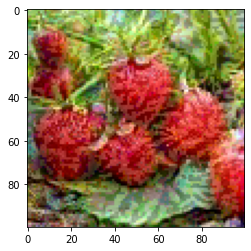

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 6 Truth: [6]


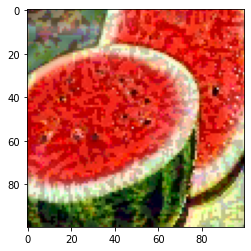

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1 Truth: [2]


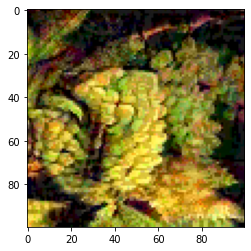

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 0 Truth: [0]


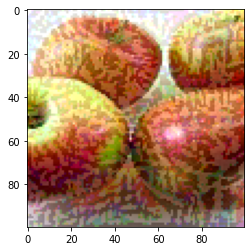

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 3 Truth: [3]


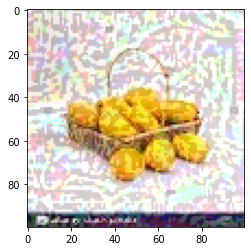

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 5 Truth: [5]


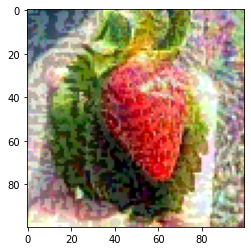

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1 Truth: [0]


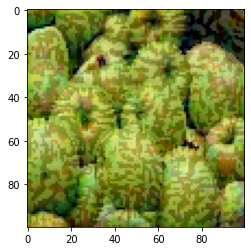

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1 Truth: [1]


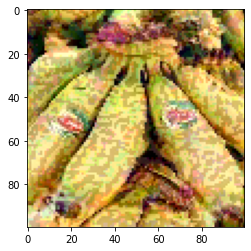

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 6 Truth: [3]


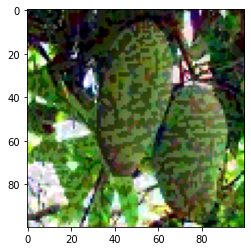

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 2 Truth: [2]


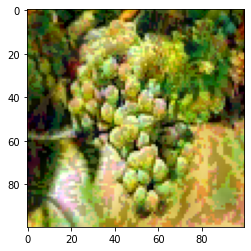

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1 Truth: [1]


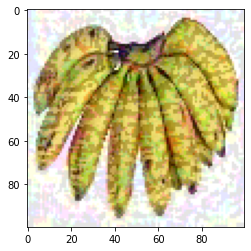

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 4 Truth: [4]


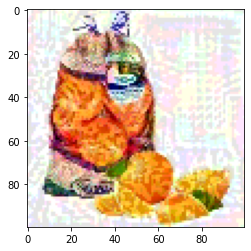

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1 Truth: [1]


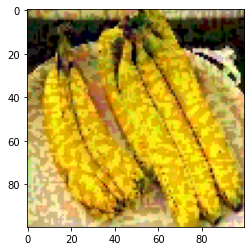

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1 Truth: [0]


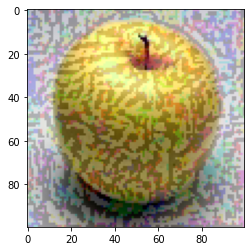

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 0 Truth: [0]


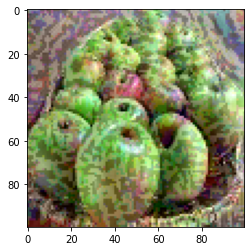

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 6 Truth: [6]


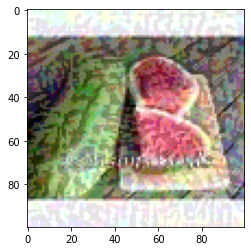

In [ ]:
# Generate and visualize 12 train adversarial images
adversarials, correct_labels = next(generate_test_adversarials(20))
for adversarial, correct_label in zip(adversarials, correct_labels):
    print('Prediction:', best_model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax(), 'Truth:', correct_label)
    plt.imshow(adversarial)
    plt.show()

Adversarial test images created and stored....

In [ ]:
img_rows=100
img_cols=100
channels=3
adversarial_test_data=[]
adversarial_test_labels=[]
for i in range(test_data.shape[0]):
  image = test_data[i]
  image_label=test_labels[i]
  perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
  adversarial=image + perturbations * 0.1
  adversarial_test_data.append(adversarial)  
  adversarial_test_labels.append(image_label)  
adversarial_test_data=np.array(adversarial_test_data).reshape(-1,100,100,3)
adversarial_test_labels=np.array(adversarial_test_labels).reshape(-1,1)
print(adversarial_test_data.shape)
print(adversarial_test_labels.shape)

(560, 100, 100, 3)
(560, 1)


Here, we evaluate the best model (not fine tuned yet!) on adversarial test images.

In [ ]:
best_model.evaluate(x=adversarial_test_data, y=to_categorical(adversarial_test_labels,7), verbose=1)

18/18 [==============================] - 2s 96ms/step - loss: 1.6425 - categorical_accuracy: 0.7054


[1.6425226926803589, 0.7053571343421936]

## Fine Tuning of the Original Best Model using 100 Adversarial Images
Original best model (i.e. the model trained on regular images only) is now loaded..

In [ ]:
best_model_fine_tuned_on_100_adversarial_images = load_model('VGG16_IndusFruit_AdversarialLearning_1st Experiment_GC.h5')

100 perturbed images are generated. These images are to be used for fine tuning the original model.

In [ ]:
x_adversarial_train, y_adversarial_train = next(generate_train_adversarials(100))

Here, we are fine tuning the original model using the 100 perturbed images.

In [ ]:
best_model_fine_tuned_on_100_adversarial_images.fit(x_adversarial_train, to_categorical(y_adversarial_train,7),
          batch_size=32,
          epochs=50)

Epoch 1/50
4/4 [==============================] - 1s 350ms/step - loss: 0.8209 - categorical_accuracy: 0.7900
Epoch 2/50
4/4 [==============================] - 1s 159ms/step - loss: 0.4590 - categorical_accuracy: 0.8700
Epoch 3/50
4/4 [==============================] - 1s 158ms/step - loss: 0.8528 - categorical_accuracy: 0.7400
Epoch 4/50
4/4 [==============================] - 1s 159ms/step - loss: 0.3177 - categorical_accuracy: 0.9100
Epoch 5/50
4/4 [==============================] - 1s 158ms/step - loss: 0.2609 - categorical_accuracy: 0.9000
Epoch 6/50
4/4 [==============================] - 1s 143ms/step - loss: 0.1846 - categorical_accuracy: 0.9200
Epoch 7/50
4/4 [==============================] - 1s 157ms/step - loss: 0.1613 - categorical_accuracy: 0.9600
Epoch 8/50
4/4 [==============================] - 1s 159ms/step - loss: 0.1143 - categorical_accuracy: 0.9600
Epoch 9/50
4/4 [==============================] - 1s 158ms/step - loss: 0.0894 - categorical_accuracy: 0.9800
Epoch 10/5

Here, we are evaluating the fine tuned model on the test set of regular images.

In [ ]:
best_model_fine_tuned_on_100_adversarial_images.evaluate(x=test_data, y=to_categorical(test_labels,7), verbose=0)

[0.7815234065055847, 0.9232142567634583]

Here, we are evaluating the fine tuned model on the test set of adversarial images.

In [ ]:
best_model_fine_tuned_on_100_adversarial_images.evaluate(x=adversarial_test_data, y=to_categorical(adversarial_test_labels,7), verbose=1)

18/18 [==============================] - 1s 64ms/step - loss: 1.5917 - categorical_accuracy: 0.8143


[1.5917402505874634, 0.8142856955528259]

## Fine Tuning of the Original Best Model using 1000 Adversarial Images

Again, we load the original best model trained only on regular images. The model is also evaluated on the regular images test set:

In [ ]:
best_model_fine_tuned_on_1000_adversarial_images = load_model('VGG16_IndusFruit_AdversarialLearning_1st Experiment_GC.h5')
best_model_fine_tuned_on_1000_adversarial_images.evaluate(x=test_data, y=to_categorical(test_labels,7), verbose=0)

[0.19632504880428314, 0.9517857432365417]

Now, we generate 1000 adversarial train samples:

In [ ]:
x_adversarial_train, y_adversarial_train = next(generate_train_adversarials(1000))

Here, we fine tune the original model using the 1000 adversarial train images generated:

In [ ]:
best_model_fine_tuned_on_1000_adversarial_images.fit(x_adversarial_train, to_categorical(y_adversarial_train,7),
          batch_size=32,
          epochs=50)

Epoch 1/50
32/32 [==============================] - 7s 226ms/step - loss: 0.5273 - categorical_accuracy: 0.8380
Epoch 2/50
32/32 [==============================] - 7s 208ms/step - loss: 0.1372 - categorical_accuracy: 0.9610
Epoch 3/50
32/32 [==============================] - 7s 208ms/step - loss: 0.0420 - categorical_accuracy: 0.9880
Epoch 4/50
32/32 [==============================] - 7s 208ms/step - loss: 0.0159 - categorical_accuracy: 0.9990
Epoch 5/50
32/32 [==============================] - 7s 207ms/step - loss: 0.0099 - categorical_accuracy: 1.0000
Epoch 6/50
32/32 [==============================] - 7s 208ms/step - loss: 0.0075 - categorical_accuracy: 1.0000
Epoch 7/50
32/32 [==============================] - 7s 208ms/step - loss: 0.0068 - categorical_accuracy: 1.0000
Epoch 8/50
32/32 [==============================] - 7s 208ms/step - loss: 0.0067 - categorical_accuracy: 1.0000
Epoch 9/50
32/32 [==============================] - 7s 208ms/step - loss: 0.0065 - categorical_accuracy:

The fine tuned model is now evaluated on the test set of regular images:

In [ ]:
best_model_fine_tuned_on_1000_adversarial_images.evaluate(x=test_data, y=to_categorical(test_labels,7), verbose=0)

[1.0626760721206665, 0.9375]

The fine tuned model is then evaluated on the adversarial test images:

In [ ]:
best_model_fine_tuned_on_1000_adversarial_images.evaluate(x=adversarial_test_data, y=to_categorical(adversarial_test_labels,7), verbose=1)

18/18 [==============================] - 1s 65ms/step - loss: 1.3729 - categorical_accuracy: 0.8839


[1.3729454278945923, 0.8839285969734192]

## Fine Tuning of the Original Best Model using 2000 Adversarial Images
First, the original best model is loaded. The model has been trained solely on regular images. 

In [ ]:
best_model_fine_tuned_on_2000_adversarial_images = load_model('VGG16_IndusFruit_AdversarialLearning_1st Experiment_GC.h5')
best_model_fine_tuned_on_2000_adversarial_images.evaluate(x=test_data, y=to_categorical(test_labels,7), verbose=0)

[0.19632504880428314, 0.9517857432365417]

2000 train adversarial images are generated:

In [ ]:
x_adversarial_train, y_adversarial_train = next(generate_train_adversarials(2000))

The original best model is fine tuned using the 2000 generated adversarial train images:

In [ ]:
best_model_fine_tuned_on_2000_adversarial_images.fit(x_adversarial_train, to_categorical(y_adversarial_train,7),
          batch_size=32,
          epochs=50)

Epoch 1/50
63/63 [==============================] - 14s 223ms/step - loss: 0.4206 - categorical_accuracy: 0.8750
Epoch 2/50
63/63 [==============================] - 13s 211ms/step - loss: 0.1123 - categorical_accuracy: 0.9645
Epoch 3/50
63/63 [==============================] - 13s 211ms/step - loss: 0.0428 - categorical_accuracy: 0.9895
Epoch 4/50
63/63 [==============================] - 13s 211ms/step - loss: 0.0158 - categorical_accuracy: 0.9985
Epoch 5/50
63/63 [==============================] - 13s 212ms/step - loss: 0.0071 - categorical_accuracy: 1.0000
Epoch 6/50
63/63 [==============================] - 13s 211ms/step - loss: 0.0065 - categorical_accuracy: 1.0000
Epoch 7/50
63/63 [==============================] - 13s 210ms/step - loss: 0.0066 - categorical_accuracy: 1.0000
Epoch 8/50
63/63 [==============================] - 13s 212ms/step - loss: 0.0063 - categorical_accuracy: 1.0000
Epoch 9/50
63/63 [==============================] - 13s 212ms/step - loss: 0.0064 - categorical_

Fine tuned model is evaluated on the test set of regular images:

In [ ]:
best_model_fine_tuned_on_2000_adversarial_images.evaluate(x=test_data, y=to_categorical(test_labels,7), verbose=0)

[0.8097214102745056, 0.9392856955528259]

Fine tuned model is evaluated on the test set of adversarial images:

In [ ]:
best_model_fine_tuned_on_2000_adversarial_images.evaluate(x=adversarial_test_data, y=to_categorical(adversarial_test_labels,7), verbose=1)

18/18 [==============================] - 1s 65ms/step - loss: 1.6006 - categorical_accuracy: 0.9018


[1.6006377935409546, 0.9017857313156128]

## Fine Tuning of the Original Best Model using 3000 Adversarial Images

The original best model is loaded again.

In [ ]:
best_model_fine_tuned_on_3000_adversarial_images = load_model('VGG16_IndusFruit_AdversarialLearning_1st Experiment_GC.h5')
best_model_fine_tuned_on_3000_adversarial_images.evaluate(x=test_data, y=to_categorical(test_labels,7), verbose=0)

[0.19632504880428314, 0.9517857432365417]

3000 adversarial train images are generated:

In [ ]:
x_adversarial_train, y_adversarial_train = next(generate_train_adversarials(3000))

The original best model is fine tuned using the generated 3000 adversarial train images: 

In [ ]:
best_model_fine_tuned_on_3000_adversarial_images.fit(x_adversarial_train, to_categorical(y_adversarial_train,7),
          batch_size=32,
          epochs=50)

Epoch 1/50
94/94 [==============================] - 22s 231ms/step - loss: 0.3178 - categorical_accuracy: 0.9057
Epoch 2/50
94/94 [==============================] - 20s 213ms/step - loss: 0.0800 - categorical_accuracy: 0.9813
Epoch 3/50
94/94 [==============================] - 20s 212ms/step - loss: 0.0564 - categorical_accuracy: 0.9860
Epoch 4/50
94/94 [==============================] - 20s 213ms/step - loss: 0.0236 - categorical_accuracy: 0.9957
Epoch 5/50
94/94 [==============================] - 20s 212ms/step - loss: 0.0280 - categorical_accuracy: 0.9933
Epoch 6/50
94/94 [==============================] - 20s 212ms/step - loss: 0.0090 - categorical_accuracy: 1.0000
Epoch 7/50
94/94 [==============================] - 20s 212ms/step - loss: 0.0066 - categorical_accuracy: 1.0000
Epoch 8/50
94/94 [==============================] - 20s 212ms/step - loss: 0.0066 - categorical_accuracy: 0.9997
Epoch 9/50
94/94 [==============================] - 20s 212ms/step - loss: 0.0060 - categorical_

The fine tuned model is evaluated on the test set of regular images:

In [ ]:
best_model_fine_tuned_on_3000_adversarial_images.evaluate(x=test_data, y=to_categorical(test_labels,7), verbose=0)

[0.679753303527832, 0.9232142567634583]

Finally, the fine tuned model is evaluated on the test set of adversarial images:

In [ ]:
best_model_fine_tuned_on_3000_adversarial_images.evaluate(x=adversarial_test_data, y=to_categorical(adversarial_test_labels,7), verbose=1)

18/18 [==============================] - 1s 65ms/step - loss: 1.1143 - categorical_accuracy: 0.9054


[1.114324688911438, 0.9053571224212646]